<a href="https://colab.research.google.com/github/rohithnagabhyrava/INFO7374/blob/master/Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


Using TensorFlow backend.


In [0]:
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [33]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
from keras.layers import Layer, Dense
from keras import backend as K

class DenseK( Layer ) :
    def __init__( self, K=3, **kwargs ) :
        self.K = K
        super( DenseK, self ).__init__( **kwargs )
    def build( self, input_shape ) :
        feat_dims = input_shape[-1]
        assert feat_dims % self.K == 0
        self.kernel = self.add_weight(shape=( 1, feat_dims ),
                                      initializer='glorot_uniform',
                                      name='kernel' )
        self.bias = self.add_weight(shape=( 1, feat_dims//self.K ),
                                      initializer='zeros',
                                      name='bias' )
        self.xk_shape = (-1, feat_dims//self.K, self.K )
    def call( self, x ) :
        # 1. element-wise product between x and kernel
        xk = x * self.kernel
        # 2. reshape xk, xk.shape = (batch_size, input_feat_dim//3, 3 )
        xk = K.reshape( xk, self.xk_shape ) 
        # 3. compute y for every K elements in xk
        y = K.sum( xk, axis=-1, keepdims=False ) + self.bias
        return y 
    def compute_output_shape( self, input_shape ) :
        batch_size, feat_dims = input_shape
        return ( batch_size, feat_dims//self.K )

In [0]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [0]:
from keras.layers import Input
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()



model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
##Custom Layer
#model.add(DenseK(K=3, name='3-neuron-dense'))
##Noise Layer
#model.add(keras.layers.GaussianNoise(0.1))
model.add(Activation('relu'))
#model.add(keras.layers.BatchNormalization())

##Batch Normalization Layer
#model.add(keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                                         # center=True, scale=True, beta_initializer='zeros',
                                          #gamma_initializer='ones', moving_mean_initializer='zeros',
                                          #moving_variance_initializer='ones', beta_regularizer=None,
                                          #gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))

model.add(Activation('softmax'))



In [0]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [39]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,steps_per_epoch=500,
                        validation_data=(x_test, y_test),
                        workers=4)

Using real-time data augmentation.
Epoch 1/100
500/500 [==============================] - 16s 33ms/step - loss: 2.0410 - acc: 0.2463 - val_loss: 1.7854 - val_acc: 0.3699
Epoch 2/100
500/500 [==============================] - 15s 31ms/step - loss: 1.7952 - acc: 0.3465 - val_loss: 1.6418 - val_acc: 0.4060
Epoch 3/100
500/500 [==============================] - 15s 31ms/step - loss: 1.7066 - acc: 0.3704 - val_loss: 1.5468 - val_acc: 0.4398
Epoch 4/100
500/500 [==============================] - 15s 30ms/step - loss: 1.6219 - acc: 0.4049 - val_loss: 1.4801 - val_acc: 0.4636
Epoch 5/100
500/500 [==============================] - 15s 30ms/step - loss: 1.5857 - acc: 0.4210 - val_loss: 1.4603 - val_acc: 0.4694
Epoch 6/100
500/500 [==============================] - 15s 31ms/step - loss: 1.5402 - acc: 0.4394 - val_loss: 1.3791 - val_acc: 0.5030
Epoch 7/100
500/500 [==============================] - 16s 31ms/step - loss: 1.5107 - acc: 0.4503 - val_loss: 1.3629 - val_acc: 0.5089
Epoch 8/100
500/500 

In [10]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


In [40]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 149us/step
Test loss: 0.715476643371582
Test accuracy: 0.7594


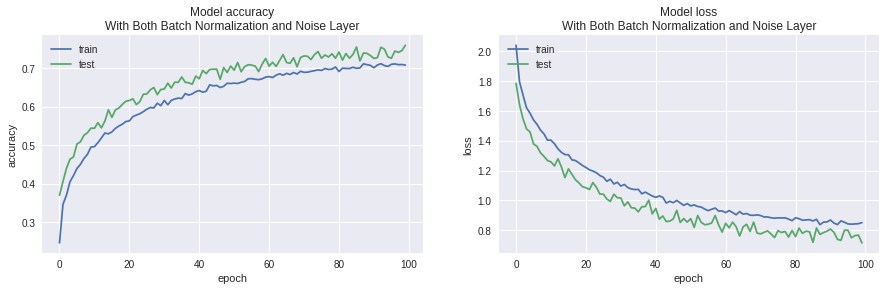

In [42]:
import matplotlib.pyplot as plt
# summarize history for accuracy
f = plt.figure(figsize=(15, 4))
f.add_subplot(1,2, 1)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title("Model accuracy\nWith Both Batch Normalization and Noise Layer")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
f.add_subplot(1,2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss\nWith Both Batch Normalization and Noise Layer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();